U ovoj bilježnici ćemo predstaviti neke aspekte izrade značajki za vremenske nizove, za nizove iz NASA-inog TurboFan podatkovnog skupa.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

Rekapitulacija: 23 senzora, 100 motora u trening skupu, za svaki motor 23 senzorska mjerenja po ciklusu do kvara, par stotina ciklusa po motoru u prosjeku.

In [83]:
column_names = ['id','cycle','setting1','setting2','setting3',
                's1','s2','s3','s4','s5','s6','s7','s8','s9',
                's10','s11','s12','s13','s14','s15','s16','s17',
                's18','s19','s20','s21', 's22', 's23']

In [84]:
train_doc = 'CMAPSSData/train_FD001.txt' 
train_data = pd.read_csv(train_doc, sep=' ', names = column_names)

Za ilustracije i lakše crtanje grafova, uzimamo samo tri motora: 52, 93, 15.

In [85]:
engines = [15, 52, 93]
df = train_data[train_data.id.isin(engines)]

In [86]:
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
2889,15,1,-0.0018,-0.0004,100.0,518.67,642.00,1576.75,1394.77,14.62,...,8142.23,8.4102,0.03,391,2388,100.0,38.87,23.3903,NaN,NaN
2890,15,2,0.0004,0.0004,100.0,518.67,642.14,1588.84,1394.27,14.62,...,8142.66,8.4101,0.03,392,2388,100.0,39.12,23.4014,NaN,NaN
2891,15,3,-0.0020,-0.0001,100.0,518.67,642.05,1581.96,1395.53,14.62,...,8140.42,8.3922,0.03,391,2388,100.0,38.89,23.4291,NaN,NaN
2892,15,4,-0.0015,-0.0001,100.0,518.67,641.97,1587.35,1393.24,14.62,...,8140.50,8.4142,0.03,392,2388,100.0,39.12,23.4905,NaN,NaN
2893,15,5,0.0014,-0.0003,100.0,518.67,642.33,1584.70,1392.44,14.62,...,8142.05,8.3915,0.03,390,2388,100.0,39.09,23.4482,NaN,NaN


Stroj 15 je izdržao 207 ciklusa prije kvara, stroj 52 213 ciklusa, stroj 93 je izdržao 155:

In [5]:
df.groupby('id').cycle.max()

id
15    207
52    213
93    155
Name: cycle, dtype: int64

# Senzori

Prvo ćemo nacrtati grafove senzorskih očitanja za ta tri motora. Kao što je danas apsolutni standard ponašanja oprati ruke čim dođemo kući, tako je u strojnoučilačkoj domeni crtanje grafova standard ponašanja čim dobijemo podatkovni set.

In [6]:
import wes

In [7]:
wes._cycles['Zissou1'] # putujemo sa Steveom Zissouom

['#3B9AB2', '#78B7C5', '#EBCC2A', '#E1AF00', '#F21A00']

In [8]:
colors = {15 : '#3B9AB2', 52 : '#EBCC2A', 93 : '#F21A00'}

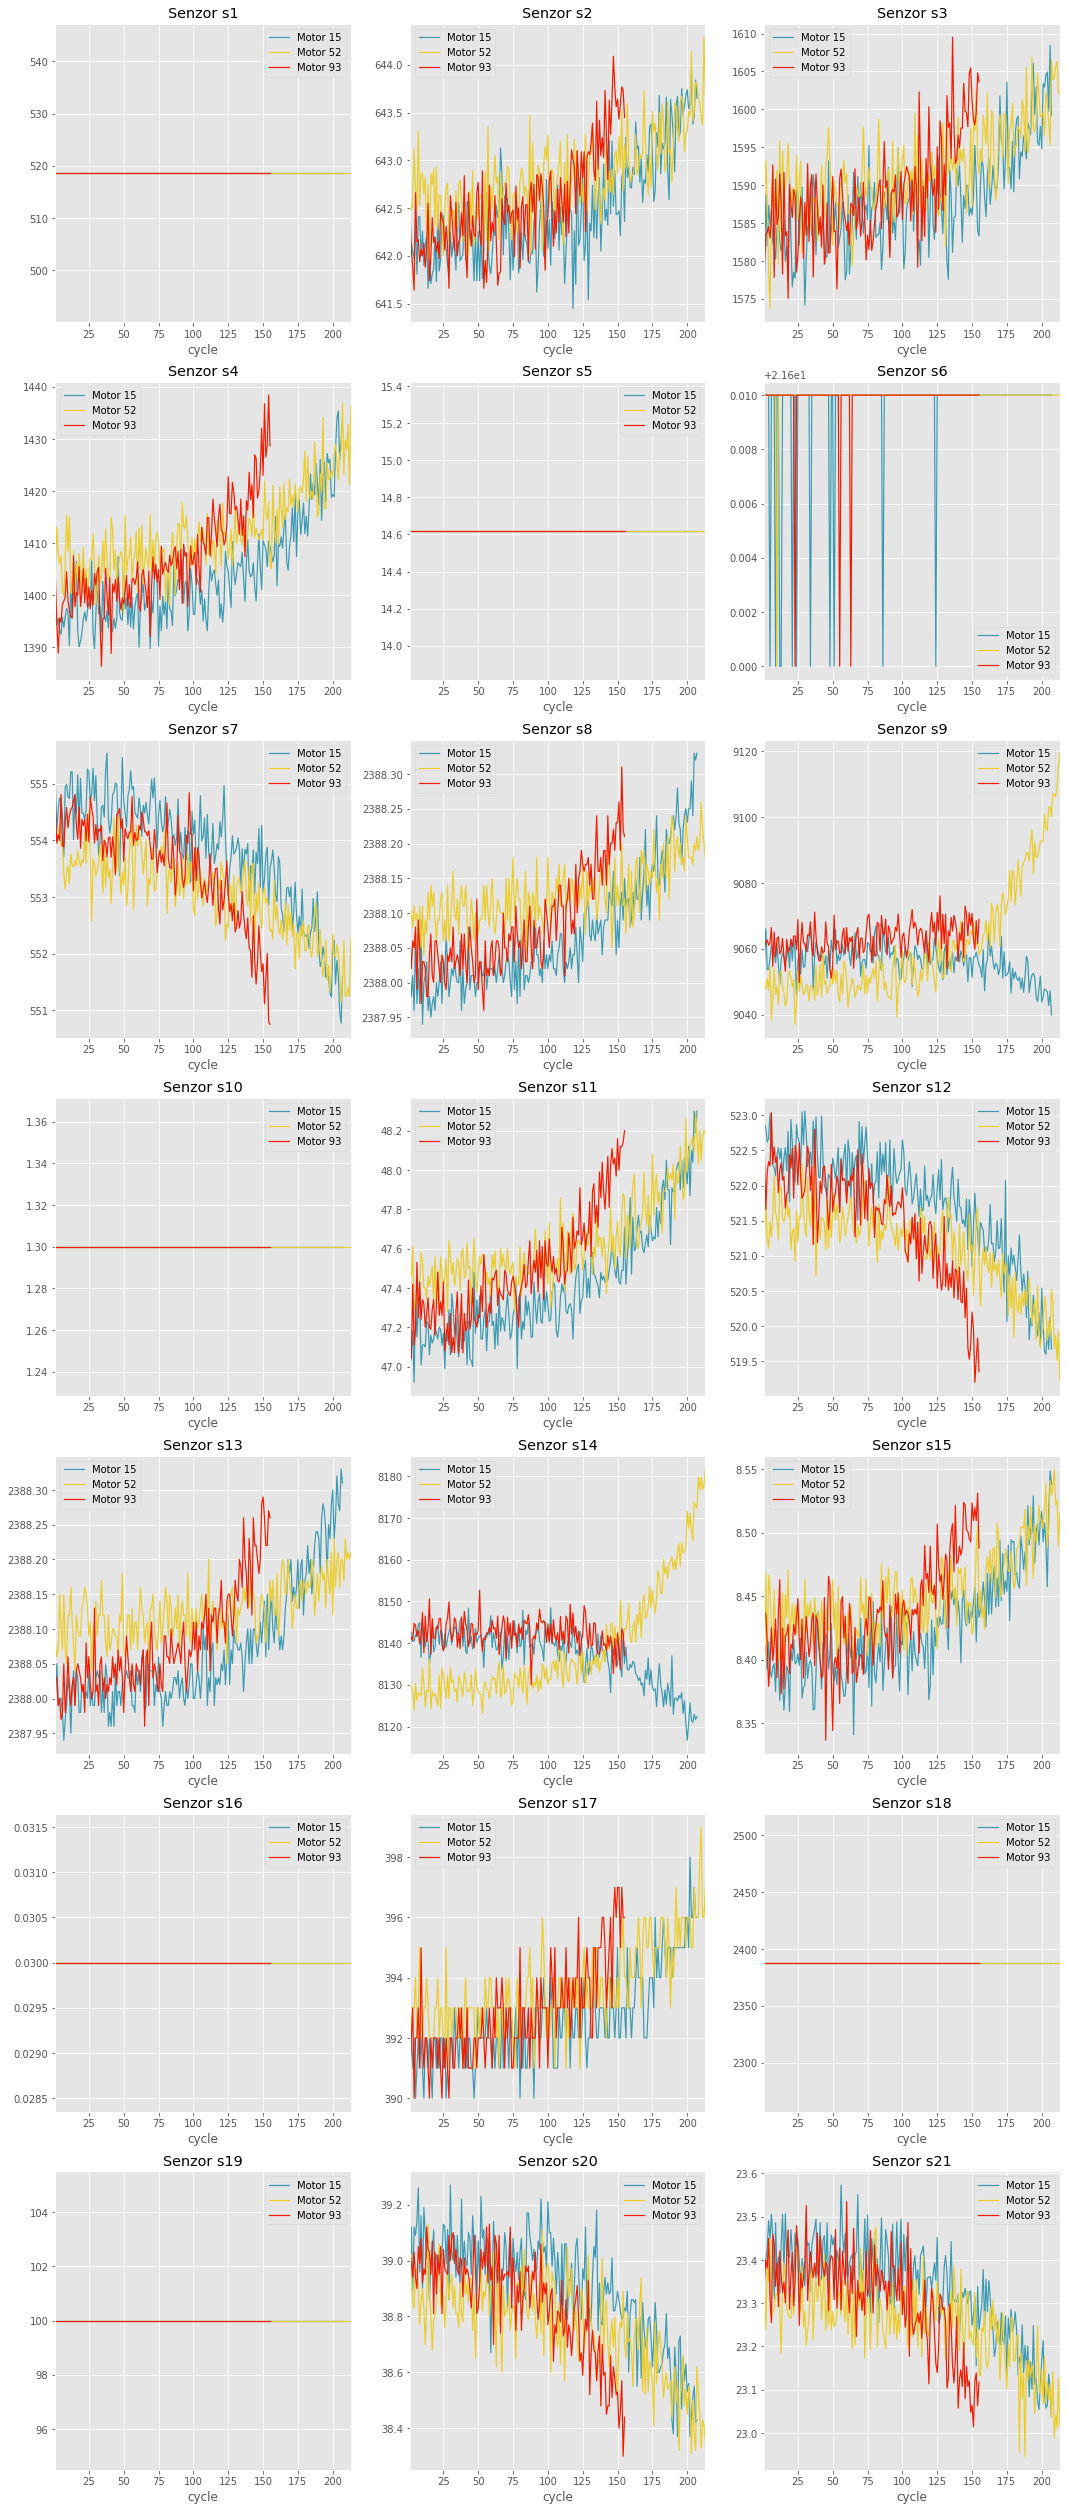

In [9]:
fig, ax = plt.subplots(7, 3, figsize=(18,45))

sensors = ['s' + str(x) for x in range(1,22)]
for ix_s, sensor in enumerate(sensors):
    for ix_e, ids in enumerate(engines):
        title = "Senzor %s" % (sensor)
        df[df.id == ids][['cycle', sensor]].set_index(['cycle']).plot(title=title, ax=ax[ix_s//3, ix_s%3],
                                                                      color=colors[ids], linewidth=1.2)
        ax[ix_s//3, ix_s%3].legend(['Motor ' + str(x) for x in engines])
plt.show()

Ilustrirat ćemo feature extraction na nekoliko primjera. Postoje dva tipa feature extractiona koje ćemo tretiranje: feature engineering koji vremenskoj seriji pridružuje još vremenskih serija, i onaj koji iz vremenske serije izvlači određene brojeve -- pretvara vremensku seriju u vektor (njezinih) značajki.

# Metode koje vraćaju vremensku seriju

Radi lakše vizualizacije, foksusirat ćemo se samo na senzor 8, senzor 9 i senzor 12.

In [10]:
sensors = ['s8', 's9', 's12']
df = df[['id', 'cycle'] + sensors]

## Rolling mean

Prvi u nizu metoda je _rolling mean_. Ona vremenskom koraku $t$ našem vremenskom nizu pridružuje značajku aritmetičke sredine vrijednosti zadnjih $k$ vremenskih koraka. Na taj nam daje "izravnatu" verziju našeg vremenskog niza, odnosno verziju koja nije toliko podložna utjecaju varijance.

Kratka teorijska digresija za one koji žele znati zašto prosjek umanjuje varijancu: Ako imamo nezavisne jednako distribuirane slučajne varijable – što definitivno nije slučaj u ovom vremenskom nizu ni u većini vremenskih nizova na koje ćete naići u životu, tako da ovo služi samo za ilustraciju – $X_1, X_2, \ldots , X_n$ s očekivanjem $\mu$ (što označavamo s $\mathbf{E}(x) = \mu$). Matematičko očekivanje je pojam čiji bi precizan opis zahtijevao više prostora nego što ga tu imamo, ali može se konceptualizirati kao nešto poput prosječne vrijednosti te slučajne varijable.

Tada je očekivanje aritmetičke sredine opet $\mu$: $$\mathbf{E}\left( \frac{ X_1 + \cdots + X_n }{n} \right) = \frac{\mathbf{E}(X_1) + \cdots + \mathbf{E}(X_n)}{n} = \frac{n\mu}{n} = \mu.$$
Varijanca aritmetičke sredine je, s druge strane $$\operatorname{Var} \left( \frac{ X_1 + \cdots + X_n }{n} \right) = \frac{1}{n^2}(\operatorname{Var}(X_1) + \cdots + \operatorname{Var}(X_n) = \frac{n\operatorname{Var}(X_1)}{n^2} = \frac{\operatorname{Var}(X_1)}{n},$$
gdje druga jednakost slijedi iz jednake distribuiranosti $X_1, \ldots X_n$, a ostale jednakosti slijede iz nezavisnosti i iz svojstva varijance.

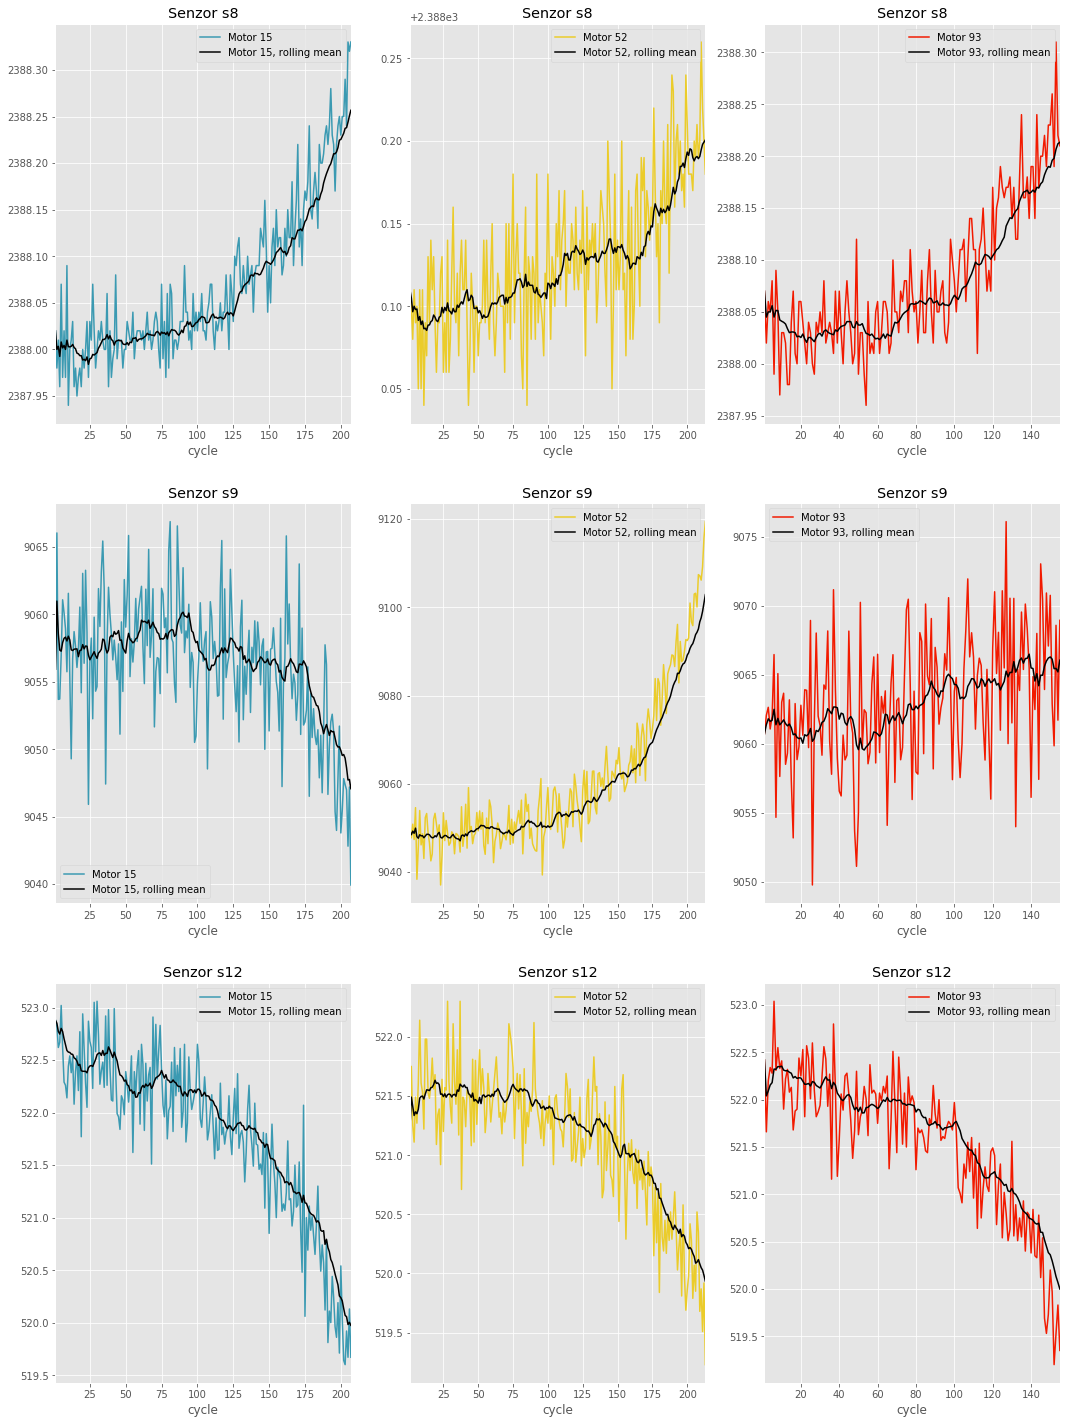

In [48]:
fig, ax = plt.subplots(3, 3, figsize=(18,25))

for ix_s, sensor in enumerate(sensors):
    for ix_e, ids in enumerate(engines):
        title = "Senzor %s" % (sensor)
        df[df.id == ids][['cycle', sensor]].set_index(['cycle']).plot(title=title, ax=ax[ix_s%3, ix_e],
                                                                      color=colors[ids])
        df['new_feature'] = df.groupby('id')[sensor].rolling(15, min_periods = 1).mean().reset_index(0,drop=True)
        df[df.id == ids][['cycle', 'new_feature']].set_index(['cycle']).plot(title=title,
                                                                             ax=ax[ix_s%3, ix_e], color='black')
        ax[ix_s%3, ix_e].legend(['Motor {}'.format(ids), 'Motor {}, rolling mean'.format(ids)])

## Rolling standard deviation

Standardna devijacija (što je isto kao drugi korijen iz varijance) je mjera raspršenja oko prosjeka. Ovdje gledamo _rolling standard deviation_ koja kao i _rolling mean_ gleda standardnu devijaciju zadnjih $k$ (specifično gledamo za $k=25$) vrijednosti.

Veća standardna devijacija, dakle, znači veću volatilnost u određenom periodu.

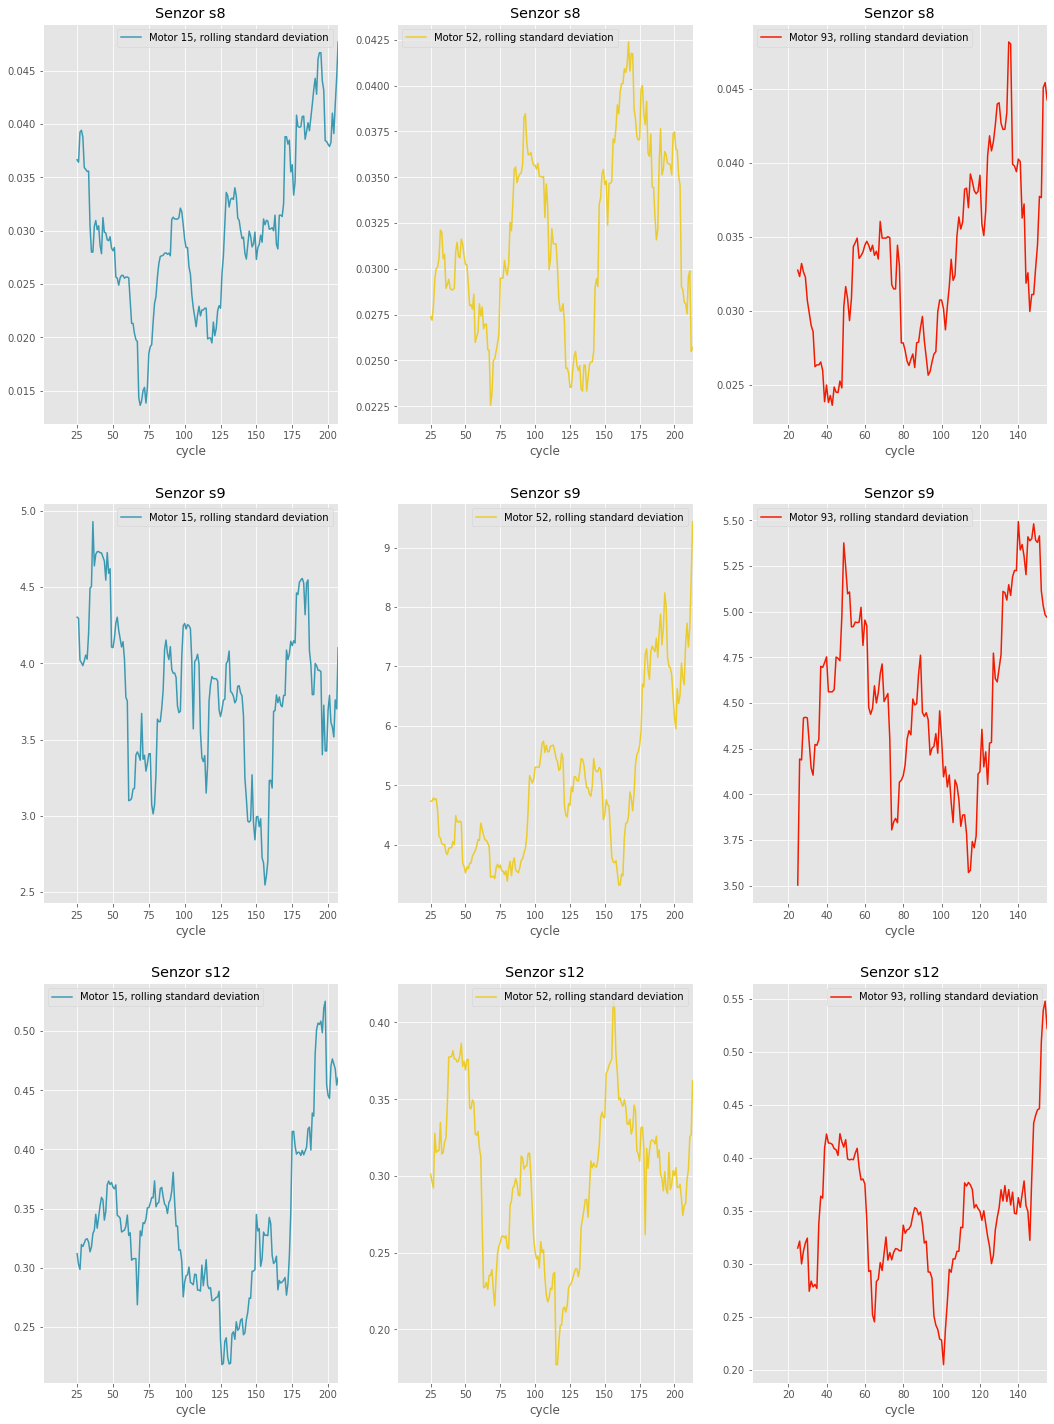

In [50]:
fig, ax =plt.subplots(3, 3, figsize=(18,25))

for ix_s, sensor in enumerate(sensors):
    for ix_e, ids in enumerate(engines):
        title = "Senzor %s" % (sensor)
        df['new_feature'] = df.groupby('id')[sensor].rolling(25, min_periods = 25).std().reset_index(0,drop=True)
        df[df.id == ids][['cycle', 'new_feature']].set_index(['cycle']).plot(title=title,
                                                                             ax=ax[ix_s%3, ix_e], color=colors[ids])
        ax[ix_s%3, ix_e].legend(['Motor {}, rolling standard deviation'.format(ids)])

# Expanding mean i expanding standard deviation

_Expanding mean_ i _expanding standard deviation_ u svakoj vremenskoj točki izračunavaju _mean_ i _standard deviation_ do te točke.

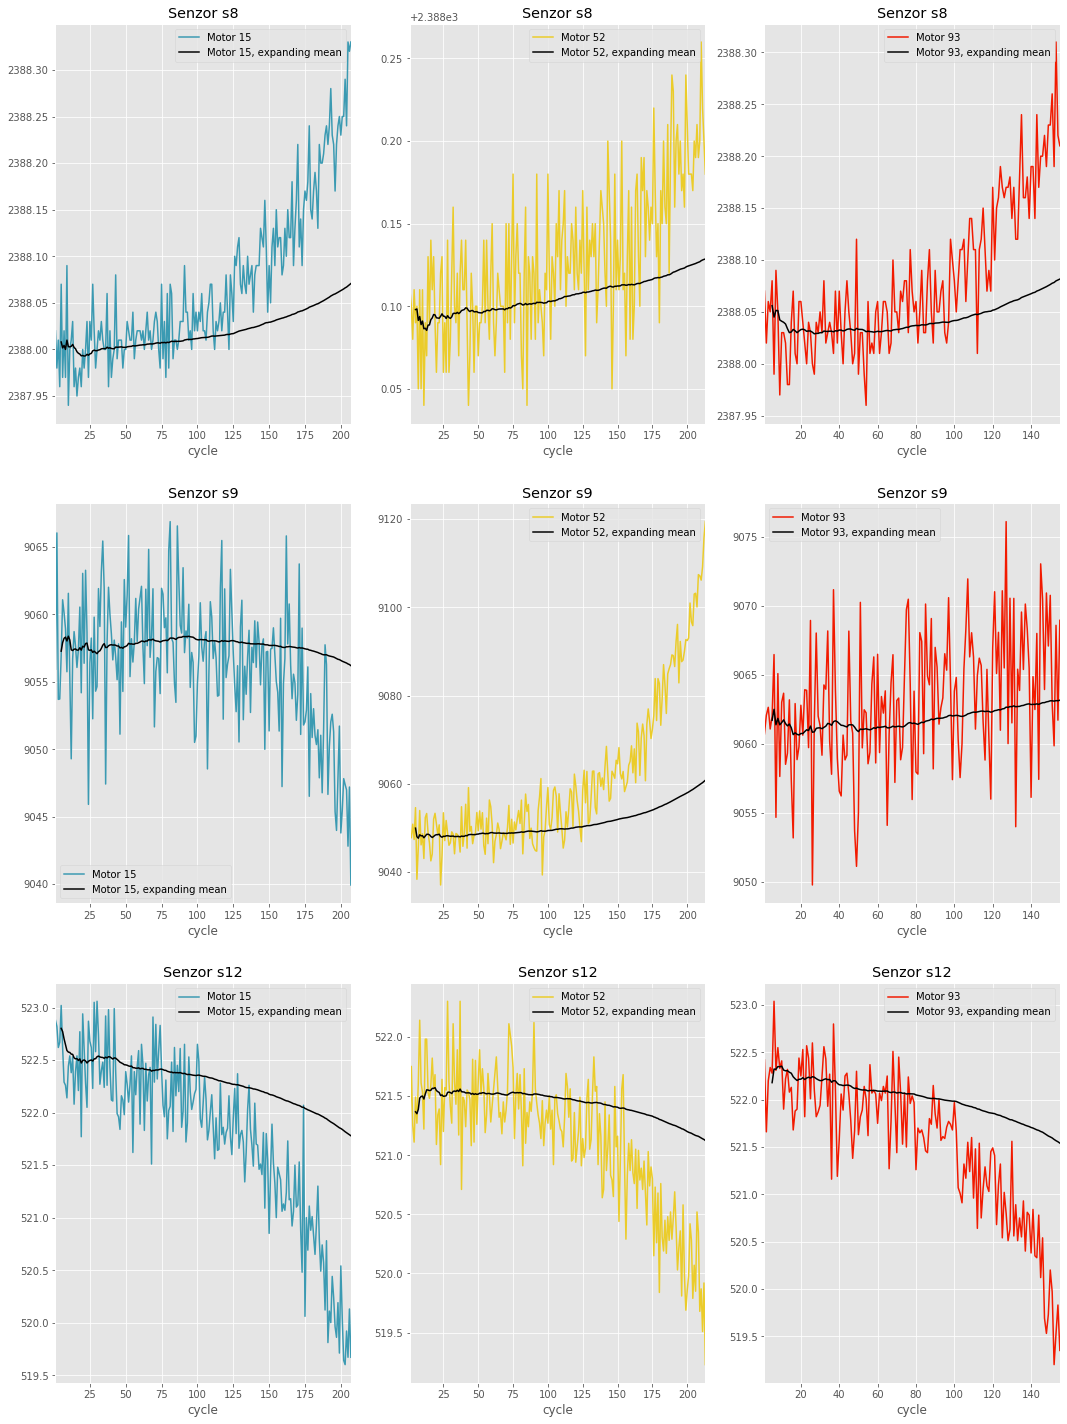

In [51]:
fig, ax =plt.subplots(3, 3, figsize=(18,25))

for ix_s, sensor in enumerate(sensors):
    for ix_e, ids in enumerate(engines):
        title = "Senzor %s" % (sensor)
        df[df.id == ids][['cycle', sensor]].set_index(['cycle']).plot(title=title, ax=ax[ix_s%3, ix_e],
                                                                      color=colors[ids])
        df['new_feature'] = df.groupby('id')[sensor].expanding(5).mean().reset_index(0,drop=True)
        df[df.id == ids][['cycle', 'new_feature']].set_index(['cycle']).plot(title=title,
                                                                                ax=ax[ix_s%3, ix_e], color='black')
        ax[ix_s%3, ix_e].legend(['Motor {}'.format(ids), 'Motor {}, expanding mean'.format(ids)])

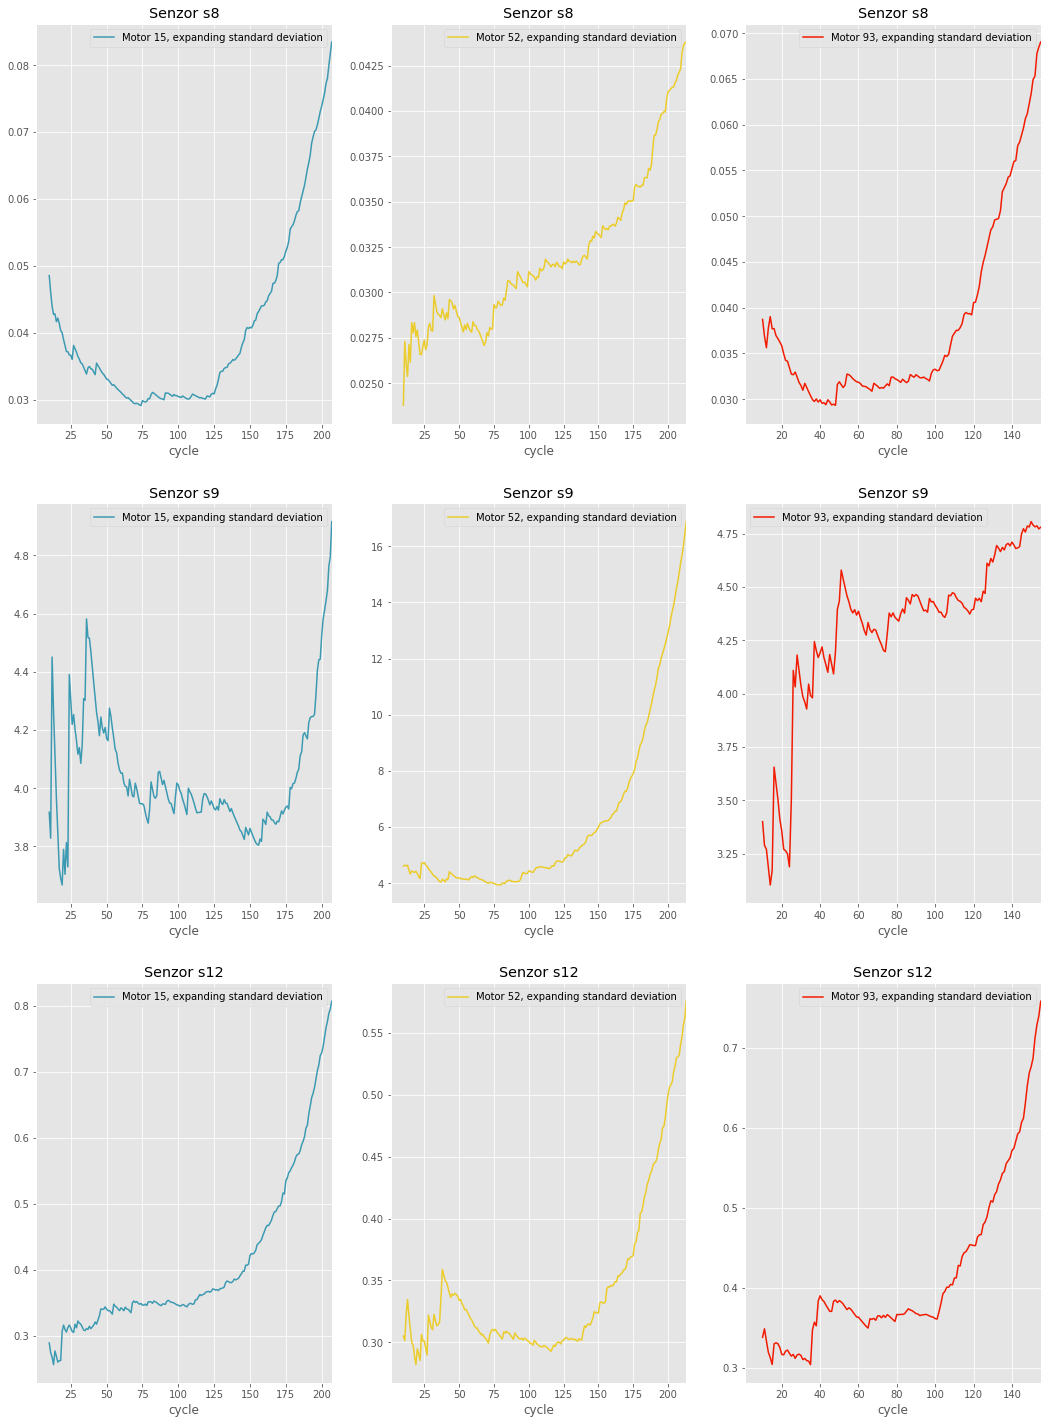

In [52]:
fig, ax =plt.subplots(3, 3, figsize=(18,25))

for ix_s, sensor in enumerate(sensors):
    for ix_e, ids in enumerate(engines):
        title = "Senzor %s" % (sensor)
        df['new_feature'] = df.groupby('id')[sensor].expanding(10).std().reset_index(0,drop=True)
        df[df.id == ids][['cycle', 'new_feature']].set_index(['cycle']).plot(title=title,
                                                                             ax=ax[ix_s%3, ix_e], color=colors[ids])
        ax[ix_s%3, ix_e].legend(['Motor {}, expanding standard deviation'.format(ids)])

# Lagovi

In [15]:
def add_lag_features(df_in, num_lags):
    
    df_temp = df_in.copy()
    sensor_cols = ['s8', 's9', 's12']    
    for sensor in sensor_cols:
        for lag in range(1,num_lags+1):
            df_temp[str(sensor) + '_lag_' + str(lag)] = df_temp.groupby('id').shift(lag).bfill()[sensor]
    return df_temp

In [16]:
lags = add_lag_features(df, 5)

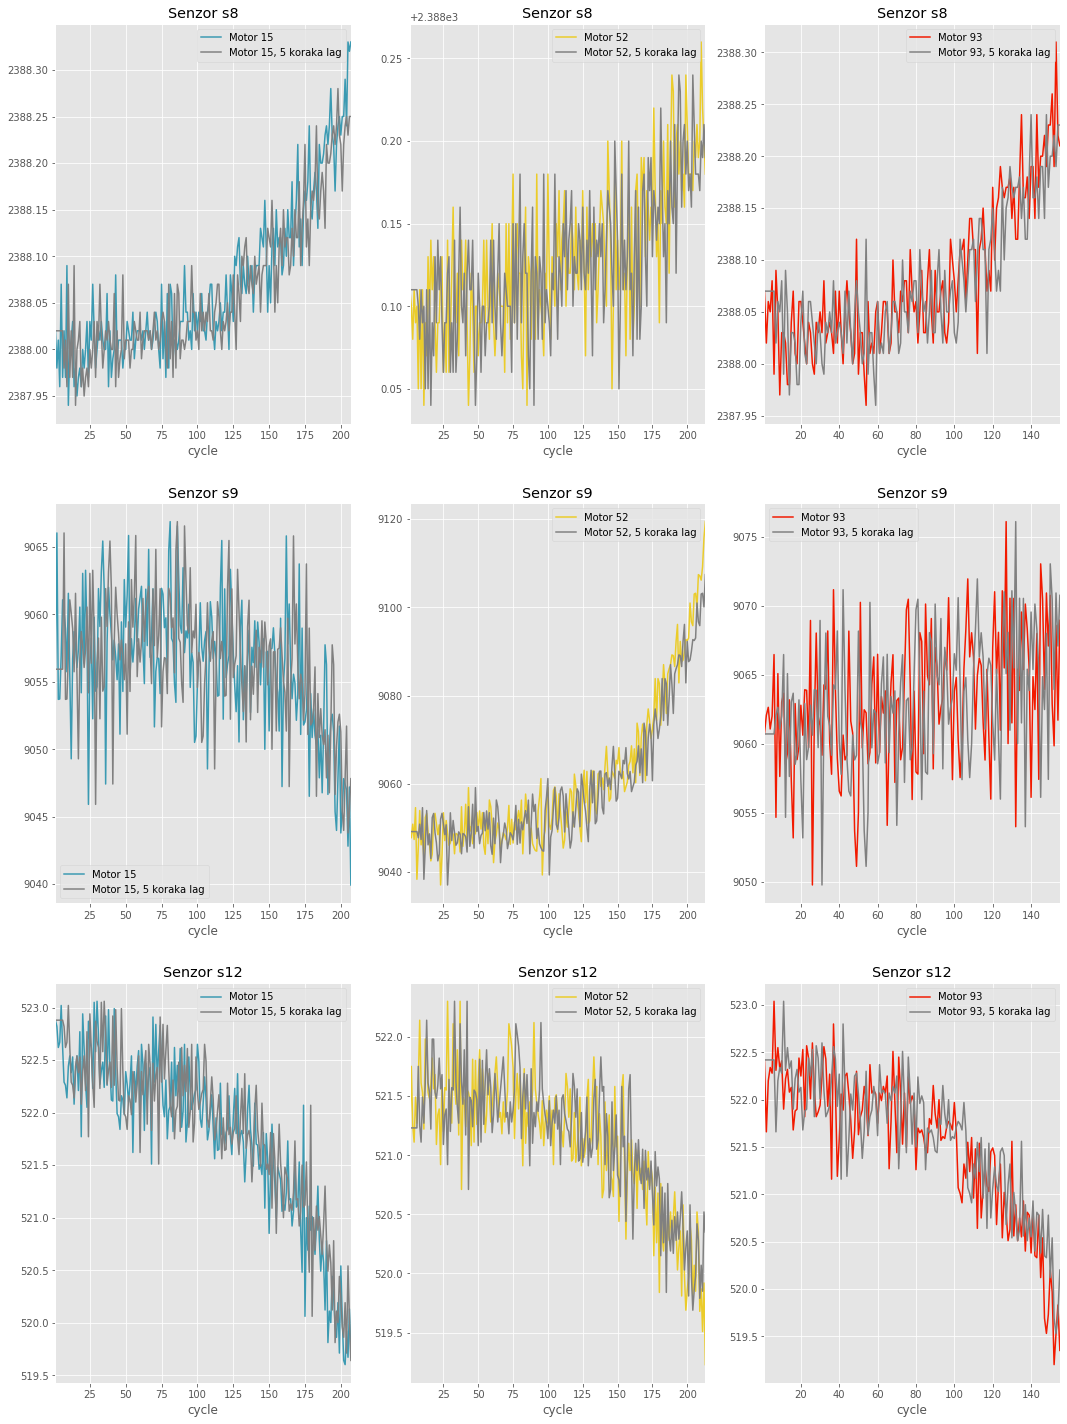

In [17]:
fig, ax =plt.subplots(3, 3, figsize=(18,25))

for ix_s, sensor in enumerate(sensors):
    for ix_e, ids in enumerate(engines):
        title = "Senzor %s" % (sensor)
        df[df.id == ids][['cycle', sensor]].set_index(['cycle']).plot(title=title,
                                                                      ax=ax[ix_s%3, ix_e], color=colors[ids])
        lags[lags.id == ids][['cycle', sensor+'_lag_5']].set_index(['cycle']).plot(title=title,
                                                                                   ax=ax[ix_s%3, ix_e], color='grey')
        ax[ix_s%3, ix_e].legend(['Motor {}'.format(ids), 'Motor {}, 5 koraka lag'.format(ids)])
        

# Metode koje vraćaju realne brojeve

Kratka teorijska digresija: prijašnje metode bi se mogle konceptualizirati kao skup funkcija $f_n : \mathbf{R}^n \to \mathbf{R}^n$, $n$ prirodan broj koji označava duljinu vremenskog niza, odnosno svaka metoda je skup funkcija koja vremenskom nizu duljine $n$ pridružuje vremenski niz duljine $n$.

Ako radimo s modelom koji može, na ovaj ili na onaj način, uzimati vremenske nizove kao ulaze, tada nam možda jedino takve metode trebaju. S druge strane, možemo se naći u situaciji – ovisno o modelima koje koristimo i prirodi našeg vremenskog niza – u kojima želimo naš vremenski niz pretvoriti u vektor fiksne, potencijalno puno manje duljine – ako ni zbog čega drugog, onda da na kompaktan način sažmemom informacije o tom vremensku nizu.

Mogli bismo si na datasetu u kojem je izrađena ova radionica zadati problem klasifikacije vremenskog niza: hoće li, za dani vremenski niz, taj motor otkazati u sljedećih 10 ciklusa? Mogli bismo uzeti samo zadnju vrijednost, s kojom bismo vjerojatno imali pristojan klasifikator, ali zbog varijance (koja je tu možda zbog senzorskog šuma, možda zbog nečeg drugog) moguće je da bi takva metoda podcijenila ili precijenila vrijednost koju "stvarno" tražimo. U slučaju da smo sigurni da su ključne informacije sadržane u njegovom samom kraju, mogli bismo onda, umjesto zadnje vrijednosti, uzeti prosjek zadnjih 5 vrijednosti; ako postoji mogućnost da su bitne i ekstremne vrijednosti van neposredne prošlosti, mogli bismo uzeti maksimum cijelog niza.

Dakle, formalizacija onoga što sada tražimo bi mogla ići ovako: skup funkcija $g_n : \mathbf{R}^n \to \mathbf{R}$, za svaki prirodan broj $n$, odnosno metoda koja nizu proizvoljne duljine pridružuje realan broj. Primijetimo, doduše, dualnost ove metode i metode s početka ove digresije; svaku ovakvu metodu možemo pretvoriti u metodu koja vraća vremenski niz tako da u $t_0$-tom koraku vremenskog niza pridružimo vrijednost $g_{t_0}(t_0)$ (e.g. ako je ta funkcija maksimum, onda bismo dobili vremenski niz vrijednosti "maksimum do tog trenutka"). Obratno, svaka metoda koja vraća vremensku seriju se može pretvoriti u metodu koja vraća realan broj, tako da umjesto vremenskog niza vrati njegovu zadnju vrijednosti.

Koristit ćemo Python paket _tsfresh_ za generiranje značajki. On može automatski izvući velik broj značajki, ali ćemo ovdje za ilustraciju promotriti tek neke. Izabirat ćemo neke nesvakidašnje, pa da onda prvo spomenemo svakidašnje: _max, min, mean, median, standard deviation_.

In [18]:
from tsfresh import extract_features
extracted_features = extract_features(df, column_id="id", column_sort="cycle")

Feature Extraction: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


Mnoge tsfreshove značajke uključuju aritmetičke operacije primijenjene na vrijednosti vremenskog niza. Nije _krivo_ primjenjivati aritmetičke operacije na _raw_ vrijednosti, ali u nekim slučajevima nam dani brojevi ništa ne znače, pa je onda teško interpretirati i značajke izrađene na temelju tih brojeva. Zbog tog razloga i srodnih ćemo napraviti i verziju _normaliziranih_ značajki.

Normalizacija u ovom slučaju znači da ćemo, za svaki senzor, podijeliti svako mjerenje aritmetičkom sredinom vrijednosti mjerenja tog senzora i podijeliti sa standardnom devijacijom vrijednosti mjerenja tog senzora. (To nije jedini način za normalizaciju vrijednosti vremenskog niza, a za diskusiju oko toga kako normalizirati specifično ovaj vremenski niz vidite [ovo CrossValidated pitanje](https://stats.stackexchange.com/questions/327192/the-correct-way-to-normalize-time-series-data).)

Dakle, nakon normalizacije je aritmetička sredina svih mjerenja danog senzora $0$, a standardna devijacija $1$. Tada npr. vrijednost $-0.7$ interpretiramo kao "$0.7$ standardnih devijacija ispod aritmetičke sredine". Takva situacija nam pogoduje i kada pravimo značajke koje uključuju kvadriranje vrijednosti, budući da mapa kvadriranja na realnim brojevima "smanjuje" (u apsolutnoj vrijednosti) brojeve $x$ takve da je $|x| < 1$, a "povećava" (u apsolutnoj vrijednosti) kad je $|x|>1$.

In [19]:
df_norm = df.copy()
for sensor in sensors:
    df_norm[sensor] = (df_norm[sensor] - df_norm[sensor].mean())/df_norm[sensor].std()

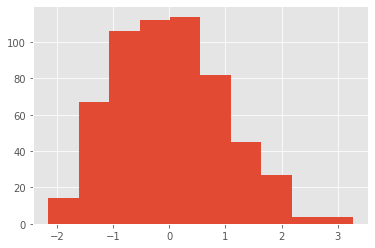

In [20]:
df_norm['s8'].hist()

In [21]:
extracted_features_norm = extract_features(df_norm, column_id="id", column_sort="cycle")

Feature Extraction: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


In [22]:
extracted_features_norm

variable,s12__abs_energy,s12__absolute_sum_of_changes,"s12__agg_autocorrelation__f_agg_""mean""__maxlag_40","s12__agg_autocorrelation__f_agg_""median""__maxlag_40","s12__agg_autocorrelation__f_agg_""var""__maxlag_40","s12__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","s12__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","s12__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","s12__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","s12__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,s9__symmetry_looking__r_0.9,s9__symmetry_looking__r_0.9500000000000001,s9__time_reversal_asymmetry_statistic__lag_1,s9__time_reversal_asymmetry_statistic__lag_2,s9__time_reversal_asymmetry_statistic__lag_3,s9__value_count__value_-1,s9__value_count__value_0,s9__value_count__value_1,s9__variance,s9__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
15,260.207443,98.385850,0.567403,0.541417,0.021598,2.530025,-0.889089,-0.150435,0.017768,2.602139,...,1.0,1.0,-0.010496,-0.035648,-0.047174,0.0,0.0,0.0,0.187825,0.0
52,162.724948,92.569361,0.509987,0.526090,0.016629,1.251249,-0.877411,-0.110432,0.013501,1.324333,...,1.0,1.0,0.855680,1.295381,1.791503,0.0,0.0,0.0,2.214033,1.0
93,151.067609,73.844690,0.467396,0.473959,0.028205,2.155301,-0.914595,-0.204809,0.024201,2.384834,...,1.0,1.0,0.003659,-0.008050,0.006428,0.0,0.0,0.0,0.177292,0.0


## Absolute energy

Apsolutna energija je suma kvadriranih vrijednosti niza; to jest, za niz $x_1, \ldots, x_t$, apsolutna energije je jednaka
$$x_1^2 + \ldots + x_t^2.$$
Printamo vrijednosti samo za normirane vremenske nizove, budući da su nenmornirano neinformativno ogromni.

In [23]:
for sensor in sensors:
    print(extracted_features_norm[str(sensor) + '__abs_energy'])

id
15    301.528872
52    125.012216
93    147.458912
Name: s8__abs_energy, dtype: float64
id
15     59.487195
52    473.322043
93     41.190762
Name: s9__abs_energy, dtype: float64
id
15    260.207443
52    162.724948
93    151.067609
Name: s12__abs_energy, dtype: float64


Promotrimo jedan slučaj, senzora 9, gdje je apsolutna energije jednog vremenskog niza vrlo različite od apsolutne energije druga dva niza:

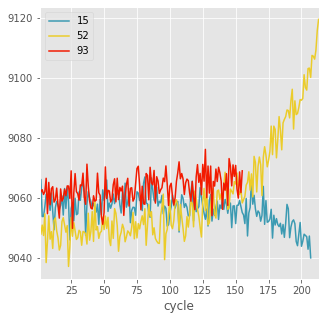

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

for ix_e, ids in enumerate(engines):
    df[df.id == ids][['cycle', 's9']].set_index(['cycle']).plot(ax=ax, color=colors[ids])
    ax.legend(engines)

Da bismo ilustrirali onu gore spominjanu dualnost, te usput pokazali malo rada s pandasom:

In [25]:
df_norm['s9_abs_eng'] = (df_norm[['id', 's9']].groupby('id')['s9'].expanding()
                        .apply(lambda x: sum(x**2), raw=True).reset_index(0,drop=True))

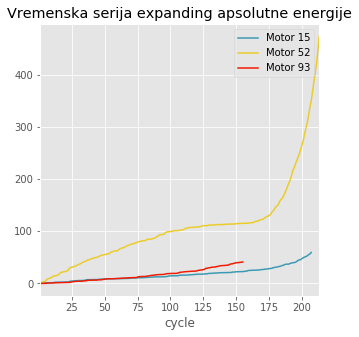

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

for ix_e, ids in enumerate(engines):
    df_norm[df_norm.id == ids][['cycle', 's9_abs_eng']].set_index(['cycle']).plot(ax=ax,
                                                                                  title="Vremenska serija expanding apsolutne energije",
                                                                                  color=colors[ids])
    ax.legend(['Motor ' + str(x) for x in engines])

A sada to isto s tsfreshom:

In [27]:
from tsfresh.feature_extraction.feature_calculators import abs_energy

df_norm['s9_abs_eng_tsfresh'] = (df_norm[['id', 's9']].groupby('id')['s9'].expanding()
                        .apply(abs_energy, raw=True).reset_index(0,drop=True))

## Absolute sum of changes

Vraća sumu razlika uzastopnih vrijednosti iz uzastopnih vremenskih koraka; to jest, za vremenski niz $x_1, \ldots, x_t$, vraća
$$\sum_{i=1}^{t-1} |x_{i+1} - x_i|.$$

In [28]:
for sensor in sensors:
    print(extracted_features_norm[str(sensor) + '__absolute_sum_of_changes'])

id
15     92.786256
52    111.148754
93     75.675747
Name: s8__absolute_sum_of_changes, dtype: float64
id
15    75.621876
52    87.415230
93    71.254164
Name: s9__absolute_sum_of_changes, dtype: float64
id
15    98.385850
52    92.569361
93    73.844690
Name: s12__absolute_sum_of_changes, dtype: float64


In [29]:
def show_expanding_graph(feature, kind="expanding"):
    if kind == "expanding":
        df_norm['s9_new_feat'] = (df_norm[['id', 's9']].groupby('id')['s9'].expanding()
                            .apply(feature, raw=True).reset_index(0,drop=True))
    elif kind == "rolling":
        df_norm['s9_new_feat'] = (df_norm[['id', 's9']].groupby('id')['s9'].rolling(10)
                            .apply(feature, raw=True).reset_index(0,drop=True))
    fig, ax = plt.subplots(1, 1, figsize=(5,5))

    for ix_e, ids in enumerate(engines):
        df_norm[df_norm.id == ids][['cycle', 's9_new_feat']].set_index(['cycle']).plot(ax=ax, color=colors[ids])
        ax.legend(['Motor ' + str(x) for x in engines])

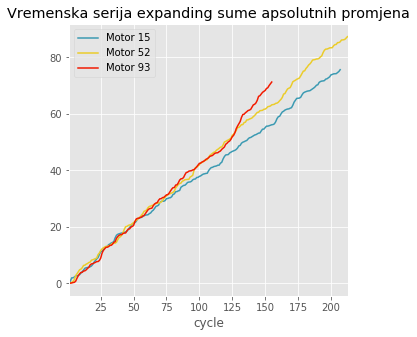

In [30]:
from tsfresh.feature_extraction.feature_calculators import absolute_sum_of_changes

show_expanding_graph(absolute_sum_of_changes)
plt.title("Vremenska serija expanding sume apsolutnih promjena")
plt.show()

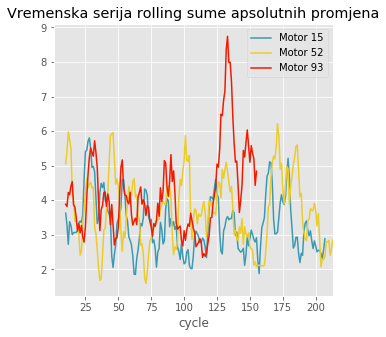

In [31]:
show_expanding_graph(absolute_sum_of_changes, "rolling")
plt.title("Vremenska serija rolling sume apsolutnih promjena")
plt.show()

## Mean absolute change

Vraća prosječnu sumu razlika uzastopnih vrijednosti iz uzastopnih vremenskih koraka; to jest, za vremenski niz $x_1, \ldots, x_t$, vraća
$$\frac{1}{t}\sum_{i=1}^{t-1} |x_{i+1} - x_i|.$$

In [32]:
for sensor in sensors:
    print(extracted_features_norm[str(sensor) + '__mean_abs_change'])

id
15    0.450419
52    0.524287
93    0.491401
Name: s8__mean_abs_change, dtype: float64
id
15    0.367096
52    0.412336
93    0.462689
Name: s9__mean_abs_change, dtype: float64
id
15    0.477601
52    0.436648
93    0.479511
Name: s12__mean_abs_change, dtype: float64


C:\Users\lpesut\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


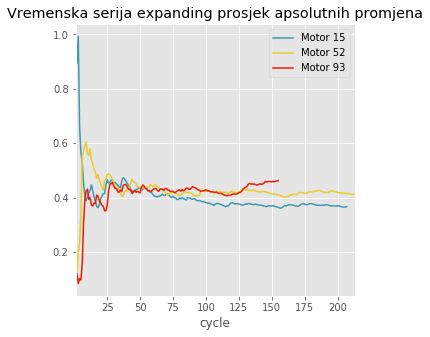

In [33]:
from tsfresh.feature_extraction.feature_calculators import mean_abs_change

show_expanding_graph(mean_abs_change)
plt.title("Vremenska serija expanding prosjek apsolutnih promjena")
plt.show()

## Skewness

Vraća _skewness_ vremenskog niza, takozvani koeficijent asimetrije, odnosno specifično njegov procjenitelj u obliku _adjusted Fisher-Pearson standardized moment coefficient_; to jest, za vremenski niz $x_1, \ldots, x_t$, vraća
$$\frac{\sqrt{n(n-1)}}{n-2}\left[ \frac{ \frac{1}{n} \sum_{i=1}^t (x_i - \mu)^3 }{ \left( \frac{1}{n}\sum_{i=1}^t (x_i - \mu)^2 \right)^{3/2} } \right],$$
gdje je $\mu$ aritmetička sredina vrijednosti vremenskog niza. To je pristran procjenitelj trećeg centralnog momenta, za slučajnu varijablu $X$ to je
$$\mathbf{E}\left[ \left( \frac{X-\mu}{\sigma}  \right)^3 \right],$$
gdje je $\mu$ očekivane te slučajne varijable, a $\sigma$ njezina standardna devijacija. Vrlo ugrubo govoreći, predznak skewnessa oznčava je li distribucija slučajne varijable više "koncentrirana na desno" ili "koncentrirana na lijevo", ali treba napomenuti da se tu misli na distribuciju u odnosu na njezin prosjek, ne na vremensko desno ili lijevo.

In [34]:
for sensor in sensors:
    print(extracted_features_norm[str(sensor) + '__skewness'])

id
15    1.052079
52    0.353711
93    0.811192
Name: s8__skewness, dtype: float64
id
15   -0.478780
52    1.380446
93   -0.073639
Name: s9__skewness, dtype: float64
id
15   -0.906908
52   -0.769708
93   -0.897614
Name: s12__skewness, dtype: float64


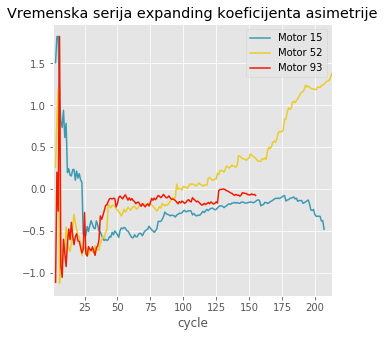

In [35]:
from tsfresh.feature_extraction.feature_calculators import skewness
show_expanding_graph(skewness)
plt.title("Vremenska serija expanding koeficijenta asimetrije")
plt.show()

## Kurtosis

Vraća _kurtosis_, takozvani koeficijent zaobljenosti ili koeficijent spljoštenosti, odnosno jednu specifična forma pristranog procjenitelja kurtosisa. Kurtosis je, za slučajnu varijablu $X$, četvrti centralni moment
$$\mathbf{E}\left[ \left( \frac{X-\mu}{\sigma}  \right)^4 \right].$$
Neka je $Z = \frac{X-\mu}{\sigma}$, tada iz definicije varijance, koja je $\operatorname{Var}(X) = \mathbf{E}(X^2) - (\mathbf{E}(X))^2$, slijedi
$$\operatorname{Var}(Z^2) = \mathbf{E}(Z^4) - (\mathbf{E}(Z^2))^2 = \mathbf{E}(Z^4) - (\operatorname{Var}(Z))^2 = \mathbf{E}(Z^4) - 1,$$
iz čega slijed da je kurtosis jednak
$$\operatorname{Var}(Z^2) + 1.$$
Dakle, kurtosis slučajne varijable mjeri varijancu te slučajne varijable, normalizirane i kvadrirane.

In [36]:
for sensor in sensors:
    print(extracted_features_norm[str(sensor) + '__kurtosis'])

id
15    0.500719
52   -0.248075
93    0.082923
Name: s8__kurtosis, dtype: float64
id
15    0.359058
52    1.242110
93   -0.197601
Name: s9__kurtosis, dtype: float64
id
15    0.277555
52    0.356769
93    0.497537
Name: s12__kurtosis, dtype: float64


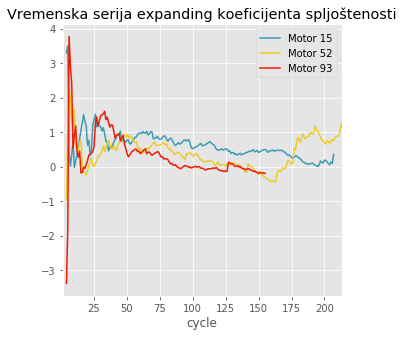

In [37]:
from tsfresh.feature_extraction.feature_calculators import kurtosis

show_expanding_graph(kurtosis)
plt.title("Vremenska serija expanding koeficijenta spljoštenosti")
plt.show()

## Longest strike above mean

_Longest strike above mean_ vraća duljinu najdužeg uzastopnog podniza našeg vremenskog niza koji je iznad prosjeka.

In [38]:
for sensor in sensors:
    print(extracted_features_norm[str(sensor) + '__longest_strike_above_mean'])

id
15    56.0
52    26.0
93    36.0
Name: s8__longest_strike_above_mean, dtype: float64
id
15     9.0
52    43.0
93     7.0
Name: s9__longest_strike_above_mean, dtype: float64
id
15    35.0
52    34.0
93    35.0
Name: s12__longest_strike_above_mean, dtype: float64


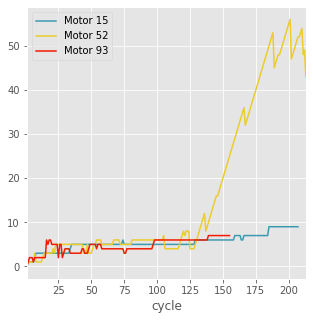

In [39]:
from tsfresh.feature_extraction.feature_calculators import longest_strike_above_mean

show_expanding_graph(longest_strike_above_mean)

## Entropija uzorka

Entropija uzorka (eng. _sample entropy_) je određena mjera kompleksnosti vremenskog niza. Za detaljnu definiciju vidite https://en.wikipedia.org/wiki/Sample_entropy .

In [41]:
for sensor in sensors:
    print(extracted_features_norm[str(sensor) + '__sample_entropy'])

id
15    2.013778
52    2.782649
93    1.990895
Name: s8__sample_entropy, dtype: float64
id
15    2.098046
52    1.713825
93    2.235745
Name: s9__sample_entropy, dtype: float64
id
15    2.027576
52    2.061967
93    2.053554
Name: s12__sample_entropy, dtype: float64


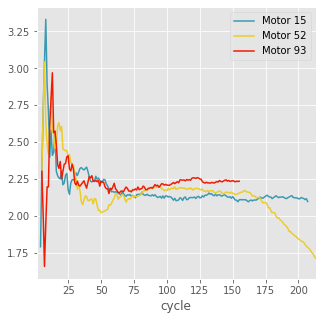

In [42]:
from tsfresh.feature_extraction.feature_calculators import sample_entropy

show_expanding_graph(sample_entropy)

## Time reversal asymmetry statistic

_Time reversal asymmetry statistics_ je vrijednost koja na određen način iskazuje asimetriju podataka. Specifično, za zadan lag $\ell$ i vremenski niz $x_1, \ldots, x_t$, ona je
$$\frac{1}{n-2\ell}\sum_{i=0}^{t-2\ell} (x_{i+2\ell}^2 x_{i+\ell} - x_{i+\ell}x_i^2),$$
što je procjenitelj od
$$\mathbf{E}[\operatorname{L}(\operatorname{L}(X))^2 \operatorname{L}(X) - \operatorname{L}(X) X^2],$$
gdje je $\operatorname{L}$ lag operator s lagom $\ell$.

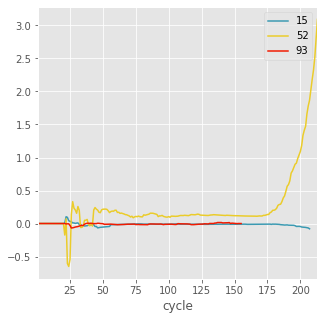

In [46]:
from tsfresh.feature_extraction.feature_calculators import time_reversal_asymmetry_statistic

df_norm['s9_new_feat'] = (df_norm[['id', 's9']].groupby('id')['s9'].expanding()
                            .apply(lambda x: time_reversal_asymmetry_statistic(x,10), raw=True).reset_index(0,drop=True))
fig, ax = plt.subplots(1, 1, figsize=(5,5))

for ix_e, ids in enumerate(engines):
    df_norm[df_norm.id == ids][['cycle', 's9_new_feat']].set_index(['cycle']).plot(ax=ax, color=colors[ids])
    ax.legend(engines)